## Installing dependencies

In [1]:
!pip install nes-py > /dev/null
!pip install gym-super-mario-bros > /dev/null

## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from abc import abstractmethod
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
import operator
import os
import pandas as pd
import pickle
from statistics import mean
from typing import List, Tuple, Union, Optional, NamedTuple
from tqdm import tqdm, trange
from tqdm.notebook import tqdm as tqdm_notebook

from nes_py.wrappers import JoypadSpace

from torch import nn
import torch

import gym
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from gym_super_mario_bros.smb_env import SuperMarioBrosEnv

## Definitions

In [ ]:
class Individual(NamedTuple('Individual', (
    ('weights', torch.Tensor),
    ))):
    def __copy__(self):
        return Individual(self.weights.copy())


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


class Network(nn.Module):
    def __init__(self, layers: nn.Module) -> None:
        super(Network, self).__init__()
        self.layers = layers

    def forward(self, state: torch.Tensor) -> int:
        output = self.layers.forward(state.view(1, 3, 240, 256))
        return torch.argmax(output).item()

    def set_weights(self, weights: torch.Tensor) -> None:
        cpt = 0
        for param in self.parameters():
            tmp = reduce(operator.mul, param.size())

            param.data.copy_(weights[cpt:cpt + tmp].view(param.size()).to(device))
            cpt += tmp

    def get_weights(self) -> Individual:
        return Individual(weights=torch.hstack([v.flatten() for v in self.parameters()]))


In [ ]:
class EvolutionaryAlgorithm:

    def __init__(
        self,
        env: JoypadSpace,
        network: Network,
        population_size: int,
        individual_len: int,
        eval_maps: int,
        eval_iters: int,
        max_iters: int,
    ) -> None:
        self.env = env
        self.population_size = population_size
        self.individual_len = individual_len
        self.eval_maps = eval_maps
        self.eval_iters = eval_iters
        self.max_iters = max_iters
        self.history_df = pd.DataFrame(columns=['iteration', 'min eval', 'mean eval', 'max eval'])
        self.network = network

        rom_mode = 'vanilla'  # The default one
        # Code from SuperMarioBrosRandomStagesEnv
        self.envs = []
        for world in range(1, 9):
            # append a new list to put this world's stages into
            self.envs.append([])
            # iterate over the stages in the world, i.e., {1, ..., 4}
            for stage in range(1, 5):
                # create the target as a tuple of the world and stage
                target = (world, stage)
                # create the environment with the given ROM mode
                env = SuperMarioBrosEnv(rom_mode=rom_mode, target=target)
                # add the environment to the stage list for this world
                self.envs[-1].append(env)
    
    @abstractmethod
    def random_population(self) -> List[Individual]:
        raise NotImplementedError()

    def evaluate(
        self, 
        individuals: List[Individual], 
        world_stages_tuples: Optional[List[Tuple[int, int]]]=None,
    ) -> List[int]:
        population_evals = np.zeros((len(individuals), self.eval_maps))

        if world_stages_tuples is None:
            world_idxs = np.random.choice(8, self.eval_maps, replace=False)
            stages_idxs = np.random.choice(4, self.eval_maps, replace=True)
            world_stages_tuples = list(zip(world_idxs, stages_idxs))

        for i, individual in tqdm_notebook(enumerate(individuals), desc='Evaluating', leave=False, total=len(individuals)):
            ind_evals = self._evaluate_individual(individual, world_stages_tuples)
            population_evals[i] = ind_evals

        mean_world_evals = np.mean(population_evals, axis=0)
        norm_mean_world_evals = mean_world_evals / sum(mean_world_evals)
        world_eval_weights = (1 - norm_mean_world_evals) / sum(1 - norm_mean_world_evals)
        return (population_evals * world_eval_weights).sum(axis=1)

    def _evaluate_individual(
        self, 
        individual: Individual, 
        world_stages_tuples: List[Tuple[int, int]],
        max_iters=None,    
    ) -> List[int]:
        if max_iters is None:
            max_iters = self.eval_iters
        
        self.network.set_weights(individual.weights)
        cumulative_rewards = []

        for world, stage in world_stages_tuples:
            # Hack for setting the enviroment to the selected world.
            self.env.env = self.envs[world][stage]
            # Need to be set before calling env.step, but wasn't as we didn't call env.reset directly.
            self.env._elapsed_steps = 0
            state = self.env.env.reset()

            current_cumulative_reward = 0

            for _ in range(max_iters):
                action = self.network.forward(torch.Tensor(state.copy()).to(device))

                state, reward, done, info = self.env.step(action)
                current_cumulative_reward += reward
                if done:
                    break
            
            cumulative_rewards.append(current_cumulative_reward)
        
        return cumulative_rewards

    @abstractmethod
    def mutate(self, parents: List[Individual]) -> List[Individual]:
        raise NotImplementedError()

    @abstractmethod
    def crossover(self, ind_1: Individual, ind_2: Individual) -> List[Individual]:
        raise NotImplementedError()

    @abstractmethod
    def selection(
        self,
        population: List[Individual],
        population_evals: List[int],
        children: List[Individual],
        children_evals: List[int]
    ) -> Tuple[List[Individual], List[int]]:
        raise NotImplementedError()

    @abstractmethod
    def parent_selection(self, population: List[Individual], evals: List[int]) -> List[Individual]:
        raise NotImplementedError()
    
    def run(self) -> None:
        best_eval = -1e5
        best_at_it = -1

        population = self.random_population()
        
        pbar = tqdm_notebook(total=self.max_iters, desc='Training', position=0, leave=True)
        
        try:
            for it in range(self.max_iters):
                evals = self.evaluate(individuals=population)

                parents = self.parent_selection(population=population, evals=evals)
                
                children = self.mutate(parents)
                children_evals = self.evaluate(individuals=children)

                population, evals = self.selection(
                    population=population,
                    population_evals=evals,
                    children=children,
                    children_evals=children_evals,
                )

                self.history_df.loc[len(self.history_df)] = [it, min(evals), mean(evals), max(evals)]
                
                if max(evals) > best_eval:
                    best_at_it = it
                    best_eval = max(evals)

                pbar.desc = f'Training (evals: {min(evals)} | {mean(evals)} | {max(evals)}, best at: {best_at_it} it)'
                pbar.update(1)
        except KeyboardInterrupt:
            pass

        pbar.close()


In [ ]:
class CEM(EvolutionaryAlgorithm):
    
    def __init__(
        self, 
        env, 
        network, 
        individual_len, 
        max_iters, 
        eval_maps, 
        eval_iters, 
        sigma_st, 
        sigma_end, 
        tau, 
        epsilon,
        population_size,
        save_name,
        elitist=None, 
        batch_size=100,
        evalutate_world_stage_tuples: Optional[List[Tuple[int, int]]]=None,
        eval_best_on_all:bool=True
    ):
        super().__init__(env, network, population_size, individual_len, eval_maps, eval_iters, max_iters)
        self.sigma_st = sigma_st
        self.sigma_end = sigma_end
        self.tau = tau
        self.epsilon = epsilon
        self.elitist = elitist
        self.batch_size = batch_size
        self.evalutate_world_stage_tuples = evalutate_world_stage_tuples
        
        if self.elitist is None:
            self.elitist = int(self.population_size//2)
        
        self.params_df = pd.DataFrame({'iteration':[], 'mean sigma': [], 'max sigma': []})
        self.history_df = pd.DataFrame(columns=['iteration', 'min eval', 'mean eval', 'max eval', 'evals for best from iter', 'best from iter'])
        self.save_name = save_name
        self.eval_best_on_all = eval_best_on_all

    def _draw_population(self, mu: float, sigma: torch.Tensor) -> List[Individual]:
        pop = [None] * self.population_size
        for i in range(self.population_size):
            pop[i] = Individual(weights=torch.normal(mu, torch.sqrt(sigma)).to(device))
        return pop
    
        
    def find_evals_for_best(self, best_individual: Individual) -> List[int]:
        evals = []
        all_world_stages_tuples = [(world, stage) for world in range(0, 8) for stage in range(0, 4)]
        if self.eval_best_on_all is False and self.evalutate_world_stage_tuples is not None:
            all_world_stages_tuples = list(filter(lambda ws: ws not in self.evalutate_world_stage_tuples, all_world_stages_tuples))
        
        for world_stage in tqdm_notebook(all_world_stages_tuples, desc='Finding all evals for best', leave=False):
            eval = self._evaluate_individual(best_individual,[world_stage], max_iters=self.eval_iters)
            evals.append(eval)
        return evals
        
    
    def run(self):
        mu = torch.ones(self.individual_len).to(device)
        sigma = self.sigma_st.to(device)
        epsilon = self.epsilon
        
        total_steps = actor_steps = 0
        
        best, best_eval, best_at_it = None, -np.inf, -1

        pbar = tqdm_notebook(total=self.max_iters, desc='Training', position=0, leave=True)

        start_it = 0

        if device == 'cuda':
            saved_cem_path = f'{self.save_name}.pkl'
        else:
            saved_cem_path = f'{self.save_name}_cpu.pkl'

        if os.path.exists(saved_cem_path):
            saved_cem = pickle.load(open(saved_cem_path, 'rb'))
            start_it = saved_cem['iteration']
            mu = saved_cem['params']['mu']
            sigma = saved_cem['params']['sigma']
            epsilon = saved_cem['params']['epsilon']

            best, best_eval = saved_cem['best'], saved_cem['best_eval']

            self.history_df = saved_cem['history_df']
            self.params_df = saved_cem['params_df']

            pbar.update(start_it)
        else:
            path_splited = saved_cem_path.split('_')
            prev_path_splited = path_splited
            prev_path_splited[3] = str(int(path_splited[3]) - 1)
            prev_path = '_'.join(prev_path_splited)
            saved_cem = pickle.load(open(prev_path, 'rb'))
            start_it = saved_cem['iteration']
            mu = saved_cem['params']['mu']
            sigma = saved_cem['params']['sigma']
            epsilon = saved_cem['params']['epsilon']

            best, best_eval = saved_cem['best'], saved_cem['best_eval']

            self.history_df.loc[0] = saved_cem['history_df'].iloc[-1]
            self.params_df.loc[0] = saved_cem['params_df'].iloc[-1]

            pbar.update(start_it)
        
        for it in range(start_it, self.max_iters):
            population = self._draw_population(mu, sigma)
            
            evals = self.evaluate(population)

            evals = np.array(evals)

            best_ind = population[np.argmax(evals)]

            evals_for_best = self.find_evals_for_best(best_ind)
            
            if evals.max() > best_eval:
                best, best_eval, best_at_it = best_ind, evals.max(), it
            
            self.history_df.loc[it] = [it, evals.min(), evals.mean(), evals.max(), evals_for_best, best_ind.weights]
            self.params_df.loc[it] = [it, sigma.mean().item(), sigma.max().item()]

            to_write = {
                'iteration': it,
                'params': {'mu': mu, 'sigma': sigma, 'epsilon': epsilon},
                'population': population,
                'best': best,
                'best_eval': best_eval,
                'history_df': self.history_df,
                'params_df': self.params_df,
            }
            pickle.dump(to_write, open(saved_cem_path, 'w+b'), 
                        pickle.HIGHEST_PROTOCOL)
            

            mu, sigma, epsilon = self._update_params(population, evals, mu, sigma, epsilon)
            

            pbar.desc = f'Training (evals: {evals.min()} | {evals.mean()} | {evals.max()}, best at: {best_at_it} it)'
            pbar.update(1)
            
        to_write = {
            'iteration': it,
            'params': {'mu': mu, 'sigma': sigma, 'epsilon': epsilon},
            'population': population,
            'best': best,
            'best_eval': best_eval,
            'history_df': self.history_df,
            'params_df': self.params_df,
        }
        pickle.dump(to_write, open(saved_cem_path, 'w+b'), 
                    pickle.HIGHEST_PROTOCOL)
            
        return best
                
    
    def _update_params(self, pop, evals, old_mu, old_sigma, epsilon):
        lambdas = torch.Tensor([torch.log(torch.Tensor([1+self.elitist]))/(1+i) for i in range(self.elitist)]).reshape(-1, 1).to(device)
        lambdas /= (lambdas.sum()+1e-10)
        idxs = np.argsort(evals)[::-1][:self.elitist]
        z = []
        for idx in idxs:
            z.append(pop[idx].weights)
        z = torch.stack(z)
        
        mu = torch.sum(torch.Tensor([list(lambdas[i]*z[i]) for i in range(self.elitist)]), dim=0)
        sigma = torch.sum(torch.Tensor([list(lambdas[i]*(z[i] - old_mu)**2) for i in range(self.elitist)]), dim=0)
        sigma += epsilon
        sigma = torch.clip(sigma, 0.4, 20)

        epsilon = self.tau*epsilon + (1-self.tau)*(self.sigma_end.mean())
        return mu, sigma, epsilon

## Initialization

In [ ]:
%cd drive/My\ Drive/mario_bros_neuroevolution

/content/drive/My Drive/mario_bros_neuroevolution


In [ ]:
env = gym_super_mario_bros.make('SuperMarioBrosRandomStages-v0')

env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [ ]:
network = Network(layers=nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=8, stride=4),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=4, stride=2),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, stride=1),
    nn.ReLU(),

    nn.Flatten(),
    nn.Linear(46592, 7),
)).to(device)

## Experiments

In [ ]:
POPULATION_SIZE = 200
INDIVIDUAL_LEN = 75936+326144+7
MAX_ITERS = 1000

agent = CEM(
    env=env,
    network=network,
    population_size=POPULATION_SIZE,
    elitist=int(POPULATION_SIZE // 4),
    individual_len=INDIVIDUAL_LEN,
    eval_maps=8,
    eval_iters=500,
    max_iters=MAX_ITERS,
    sigma_st=torch.full(torch.Size([INDIVIDUAL_LEN]), 15, dtype=torch.float32),
    sigma_end=torch.full(torch.Size([INDIVIDUAL_LEN]), 1e-3,dtype=torch.float32),
    tau=0.99,
    epsilon=5,
    save_name='saved_cem_5_3',
    eval_best_on_all=True,
)

In [ ]:
try:
    agent.run()
except KeyboardInterrupt:
    pass

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
min_evals = pd.Series([])
mean_evals = pd.Series([])
max_evals = pd.Series([])

all_eval = pd.Series([])

filenames = [f'saved_cem_5_{suffix}cpu.pkl' for suffix in ['', '_1_', '_2_', '_3_', '_4_']]
for filename in filenames:
    s = pickle.load(open(filename, 'rb'))
    min_evals = min_evals.append(s['history_df']['min eval'])
    mean_evals = mean_evals.append(s['history_df']['mean eval'])
    max_evals = max_evals.append(s['history_df']['max eval'])

    control_evals = s['history_df']['evals for best from iter']
    control_evals = np.array([[x[0] for x in level_evals] for level_evals in control_evals])

    all_eval = all_eval.append(pd.Series(control_evals.mean(axis=1)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify

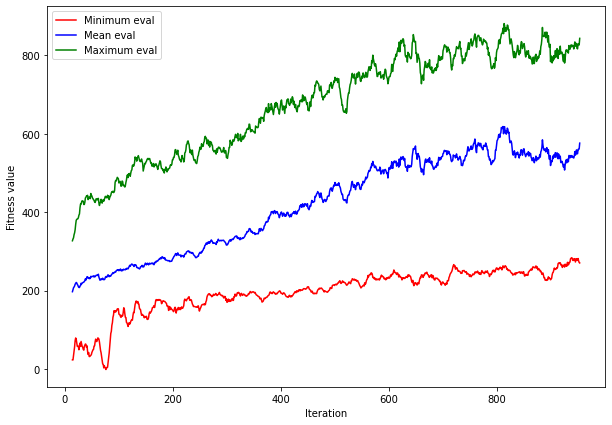

In [ ]:
plt.figure(figsize=(10, 7))
plt.title('Rolling average of 15 iteration for fitness function scores')
plt.plot(list(min_evals.rolling(15).mean().values), c='r', label='Minimum eval')
plt.plot(list(mean_evals.rolling(15).mean().values), c='b', label='Mean eval')
plt.plot(list(max_evals.rolling(15).mean().values), c='g', label='Maximum eval')
plt.xlabel('Iteration')
plt.ylabel('Fitness value')
plt.legend()

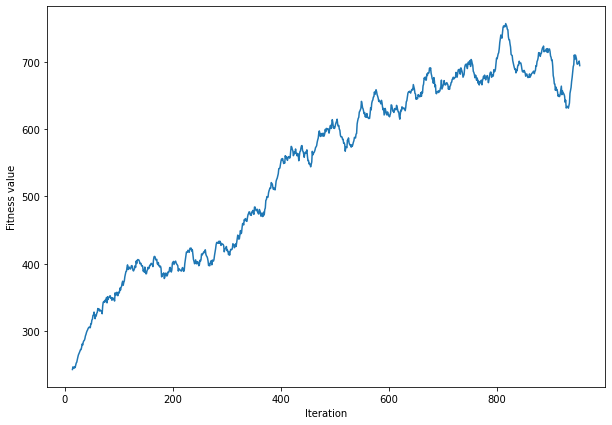

In [ ]:
plt.figure(figsize=(10, 7))
plt.title('Rolling average of 15 iteration for score on all levels of the best individual')
plt.plot(list(all_eval.rolling(15).mean().values))
plt.xlabel('Iteration')
plt.ylabel('Fitness value')